# <center>升维嵌入学习算法：求解一维 Poisson 方程的格林函数</center>

## 1. 问题描述（Poisson's Equations in One Dimension）

对于一维区间 $[0,1]$ 上的 Poisson 方程：
$$
\begin{array}{cl}
    - \partial_{xx} u(x) = f(x), \ \ \ & \ \textnormal{for}\ x\in\Omega = (0,1), \\
    u(x) = 0, \ \ \  & \ \textnormal{for}\ x\in\partial\Omega,
\end{array}
$$

其格林函数 $G(x,y)$ 满足：对任一固定 $y\in\Omega$，
$$
\begin{array}{cl}
	- \partial_{xx} G(x,y)  = \delta(x-y), \ \ \ & \ \textnormal{for}\ x\in\Omega = (0,1), \\
	G(x,y) = 0, \ \ \  & \ \textnormal{for}\ x\in\partial\Omega,
\end{array}
$$
其中 $\delta(\cdot)$ 表示 [Dirac delta 函数](https://en.wikipedia.org/wiki/Dirac_delta_function)。特别的，通过对 $\delta(\cdot)$ 函数进行积分，格林函数所满足的方程也可等价写为：对任一固定 $y\in\Omega$， 
$$
\begin{array}{cl}
    -\partial_{xx} G(x,y) = 0, \ \ \ & \ \textnormal{for}\ x\in\Omega\setminus\Gamma, \\
    【G(x,y)】 = 0,\ 【\partial_x G(x,y) 】 = -1, \ \ \ &\ \textnormal{for}\ x\in\Gamma = \{ x \,|\, x=y\},\\
	G(x,y) = 0, \ \ \ &\ \textnormal{for}\ x\in\partial\Omega,
\end{array}
$$
其中跳量符号 $【\cdot】$ 表示函数在界面 $\Gamma$ 左右两侧极限之差（此处表示：格林函数的函数值在界面处连续，但其一阶偏导数存在非零跳量）。

## 2. 升维嵌入学习方法

通过引入辅助变量 $\varphi(x,y)=|x-y|$，将原本分片光滑的格林函数 $G(x,y)$ 嵌入到高一维的空间中，即考虑如下形式的替代模型
$$
G(x,y) = \widehat{G}( x, y,  \varphi( x, y )) 
$$
并将其代回到原方程推导得出：对任一固定 $y\in\Omega$，
$$
\begin{array}{cl}
-[\partial_{xx} + \partial_{zz} + 2 \textnormal{sgn}(x-y) \partial_{x z}] \widehat{G}(x,y,\varphi(x,y)) = 0, \ &\ \ \ \mathrm{for}\ x \in \Omega\setminus\Gamma,\\
			\displaystyle -2\partial_{z}\widehat{G}(x,y,\varphi(x,y)) = 1, \ &\ \ \ \textnormal{for}\ x\in \Gamma=\{ x \,|\, x = y \},\\
			\widehat{G} (x, y, \varphi( x, y) ) = 0, \ &\ \ \ \mathrm{for}\ x \in \partial\Omega.
\end{array}
$$
注意到，格林函数 $G(x,y)$ 在界面处的不连续性由辅助变量代为刻画，因此升维函数 $\widehat{G}( x, y, z) $ 具备有充分的光滑性。

#### 函数逼近
由于辅助变量的引入导致函数自变量维数的升高，因此我们使用一个全连接网络来克服“维数灾难”的问题，即
$$
    \widehat{G}(x,y,\varphi(x,y)) \approx \widehat{G}_{NN}(x,y,\varphi(x,y))
$$
其中 $\theta$ 表示神经网络的待定参数。特别的，得益于光滑性的提升，仅需采用光滑的[激活函数](https://en.wikipedia.org/wiki/Activation_function)即可，无需做特殊设计。

#### 损失函数

通过方程的残量来定义格林函数替代模型在光滑、奇性以及边界处的损失函数，以及由格林函数本身的对称性构造的损失函数
$$
    L_{\textnormal{Reglr}} (\theta) = \frac{1}{M} \sum_{m=1}^M \bigg( \frac{1}{N_{\textnormal{R}}} \sum_{n=1}^{N_{\textnormal{R}}} 
            \bigg| \Big( \partial_{xx} + 2\textnormal{sgn}(x-y)\partial_{xz}  + \partial_{zz} \Big)\widehat{G}( x_n^{\Omega}, y_m, \varphi( x_n^{\Omega}, y_m ) ;\theta) \bigg|^2 \bigg)，
$$
$$
    L_{\textnormal{Snglr}}^{d = 1} (\theta) = \frac{1}{M} \sum_{m=1}^M \left( \big| 2\partial_z\widehat{G}( y_m, y_m, \varphi(y_m, y_m);\theta) + 1 \big|^2 \right),
$$
$$
    L_{\textnormal{Bndry}} (\theta) =  \frac{1}{M} \sum_{m=1}^M \bigg( \frac{1}{N_{\textnormal{B}}} \sum_{n=1}^{N_{\textnormal{B}}} \big|  \widehat{G}( x_n^{\partial \Omega}, y_m, \varphi( x_n^{\partial\Omega}, y_m ) ;\theta) \big|^2 \bigg),
$$
$$
    L_{\textnormal{Symtr}}( \theta ) = \frac{1}{M} \sum_{m=1}^{M}  \Bigg( \frac{1}{N_{\textnormal{R}}} \sum_{n=1}^{N_{\textnormal{R}}} \left| \widehat{G}( x_n^{\Omega}, y_m, \varphi( x_n^{\Omega}, y_m) ) - \widehat{G}( y_m, x_n^{\Omega}, \varphi( y_m, x_n^{\Omega} ) ) \right|^2 \Bigg),
$$
进而通过求解以下优化问题来近似得到神经网络的最优参数

\begin{equation*}
	\theta^* = \operatorname*{arg\, min}_\theta ~~ L_{\textnormal{Reglr}} (\theta) + \beta_{\textnormal{Snglr}} L_{\textnormal{Snglr}}^{d = 1} (\theta) + \beta_{\textnormal{Bndry}} L_{\textnormal{Bndry}} (\theta) + \beta_{\textnormal{Symtr}} L_{\textnormal{Symtr}}( \theta )
\end{equation*}
其中 $\beta_{\textnormal{Snglr}}$、$\beta_{\textnormal{Bndry}}$ 和 $\beta_{\textnormal{Symtr}}$ 为惩罚系数。

### 应用：快速求解器

在获得 Green 函数的机器学习替代模型后，一个典型的应用便是用其来快速计算任意给定外力项 $f(x)$ 所对应的位移 $u(x)$，即通过数值积分求解

\begin{equation*}
	u(x) = \int_0^1 \widehat{G}(x,y,\varphi(x,y)) f(y) dy \approx \sum^{N}_{i=0} w_i \widehat{G}(x,y_i,\varphi(x,y_i)) f(y_i)
\end{equation*}

其中 $\{ w_i, y_i \}_{i=0}^N$ 为数值积分公式中权重与节点所组成的集合，例如梯形公式 **(Trapezoidal Rule)** 等。


## 3.编程求解

### 3-1. 准备工作 - 调用函数库

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import datetime
import argparse 

from torch import optim, autograd
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

# matlab to tensor and vice versa
from scipy.io import loadmat
import numpy as np
import scipy.io as io

# load data from two datasets within the same loop
from itertools import cycle

print("pytorch version", torch.__version__, "\n")
torch.set_default_dtype(torch.float64)

pytorch version 2.4.0 



### 3-1. 准备工作 - 全连接神经网络

In [2]:
class FcBlock(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of each block's output data (not the dimension of final output)  
    """
    
    def __init__(self, dim_in, width, dim_out):
        super(FcBlock, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out

        # create linear layers
        self.Linear1 = nn.Linear(dim_in, width)
        self.Linear2 = nn.Linear(width, dim_out)  
        # choose activation function = Tanh
        self.activation = nn.Tanh()      

    def forward(self, x):
        
        return self.activation(self.Linear2(self.activation(self.Linear1(x))))


class FcNet(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of final output data   
    """

    def __init__(self, dim_in, width, dim_out, depth):
        super(FcNet, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out
        self.depth = depth

        # creat a list for holding all blocks/layers
        self.stack = nn.ModuleList()
                
        # input layer       
        self.stack.append(nn.Linear(dim_in, width))
        # add hidden blocks
        for i in range(depth):
            self.stack.append(FcBlock(width, width, width))        
        # output layer
        self.stack.append(nn.Linear(width, dim_out))  
        
    def forward(self, x):
        
        for layer in self.stack:
            x = layer(x)

        return x

    def Xavier_initi(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()  

## 3-1. 准备工作 - 训练和测试数据集（先对自变量 $x, y$ 进行采样）

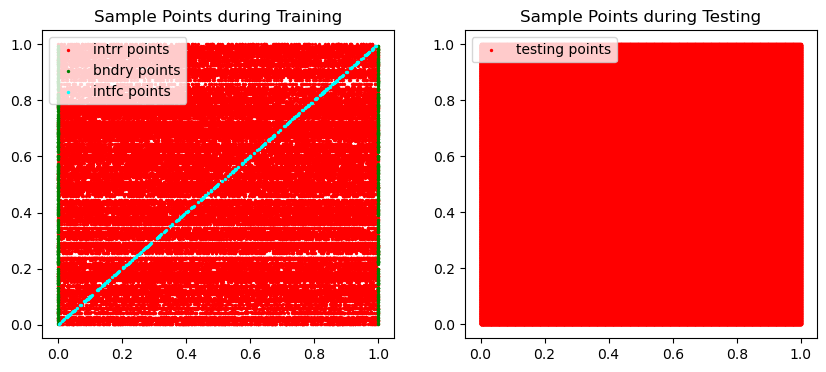

In [3]:
# computational domain
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# number of collocation points for each part
traindata_size_intrr_x = 200
traindata_size_intrr_y = 300
traindata_size_bndry_x = 2 
traindata_size_intfc_x = 300

# generate testing points over the entire domain
x = torch.linspace(0, 1, steps=1001)
y = torch.linspace(0, 1, steps=1001)
X, Y = torch.meshgrid(x, y, indexing="ij")
testdata = torch.squeeze(torch.stack([X.reshape(1,1001*1001), Y.reshape(1,1001*1001)], dim=-1))

# generate training points for each part
def SmpPts_Interior_Line1D(traindata_size_intrr_x, traindata_size_intrr_y):
    
    # generate sample points of y
    IntrrPts_y = torch.rand(traindata_size_intrr_y,1) 
    IntrrPts_y_Reshape = torch.reshape( IntrrPts_y.repeat(1, traindata_size_intrr_x), (traindata_size_intrr_x*traindata_size_intrr_y, 1) )

    # generate sample points of x for each y
    IntrrPts_x_Reshape = torch.rand(traindata_size_intrr_x,1) 
    for i in range(traindata_size_intrr_y-1):
        IntrrPts_x_Reshape = torch.cat( (IntrrPts_x_Reshape, torch.rand(traindata_size_intrr_x,1)), 1)
    IntrrPts_x_Reshape = IntrrPts_x_Reshape.view(-1, 1) 
        
    return torch.cat((IntrrPts_x_Reshape, IntrrPts_y_Reshape),1)

def SmpPts_Boundary_Line1D(traindata_size_bndry_x, traindata_size_intrr_y): 
    BndryPts_x = torch.tensor([[0], [1]])
    IntrrPts_y = torch.rand(traindata_size_intrr_y,1)
    BndryPts_x_Reshape = BndryPts_x.repeat(traindata_size_intrr_y,1)
    IntrrPts_y_Reshape = torch.reshape(IntrrPts_y.repeat(1,traindata_size_bndry_x), (traindata_size_bndry_x*traindata_size_intrr_y,1))
    
    return torch.cat((BndryPts_x_Reshape,IntrrPts_y_Reshape),1)

def SmpPts_Intfc_Line1D(traindata_size_intfc_x):
    Intfc_x = torch.rand(traindata_size_intfc_x,1)
    
    return Intfc_x.repeat(1,2)

smppts_intrr = SmpPts_Interior_Line1D(traindata_size_intrr_x, traindata_size_intrr_y)
smppts_bndry = SmpPts_Boundary_Line1D(traindata_size_bndry_x, traindata_size_intrr_y)
smppts_intfc = SmpPts_Intfc_Line1D(traindata_size_intfc_x)

fig = plt.figure(figsize=(10, 4), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(smppts_intrr[:,0], smppts_intrr[:,1], c = 'red', label = 'intrr points', s=2)
plt.scatter(smppts_bndry[:,0], smppts_bndry[:,1], c = 'green', label = 'bndry points', s=2)
plt.scatter(smppts_intfc[:,0], smppts_intfc[:,1], c = 'cyan', label = 'intfc points', s=2)
plt.title('Sample Points during Training')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.scatter(testdata[:,0], testdata[:,1], c = 'red', label = 'testing points', s=2)
plt.title('Sample Points during Testing')
plt.legend(loc = 'upper left')
plt.show()

## 3-1. 准备工作 - 训练和测试数据集（再计算升维函数在样本点处的函数值）

In [4]:
# define auxiliary variable
# TODO: write code
# def augmented_variable(x, y): ？？？？    

# append the value of auxiliary variable for each input data point
smppts_intrr = torch.cat([smppts_intrr, augmented_variable(smppts_intrr[:,0], smppts_intrr[:,1]).reshape(-1,1)], dim=1)
smppts_bndry = torch.cat([smppts_bndry, augmented_variable(smppts_bndry[:,0], smppts_bndry[:,1]).reshape(-1,1)], dim=1)
smppts_intfc = torch.cat([smppts_intfc, augmented_variable(smppts_intfc[:,0], smppts_intfc[:,1]).reshape(-1,1)], dim=1)
smppts_test = torch.cat([testdata, augmented_variable(testdata[:,0], testdata[:,1]).reshape(-1,1)], dim=1)

# exact solution 
def Green_Exact_Line1D(x, y):
    return x * (1-y) * (x<=y) + y * (1-x) * (x>y)

# load train data in mini-batches
batch_num = 4
batchsize = traindata_size_intrr_x * traindata_size_intrr_y // batch_num

dataset_intrr = TensorDataset(smppts_intrr)
dataset_bndry = TensorDataset(smppts_bndry)
dataset_intfc = TensorDataset(smppts_intfc)
dataloader_intrr= DataLoader(dataset_intrr, batch_size=batchsize, shuffle=True)
dataloader_bndry= DataLoader(dataset_bndry, batch_size=batchsize, shuffle=True)
dataloader_intfc= DataLoader(dataset_intfc, batch_size=batchsize, shuffle=True)

## 3-2. 网络训练

Done in 0:13:12.108098 !


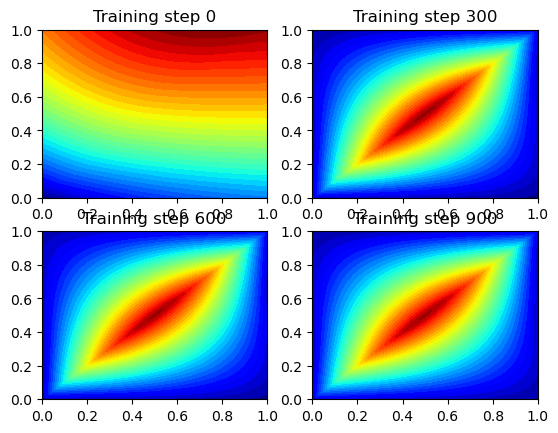

In [5]:
# penalty coefficient
beta_intrr = 20
beta_bndry = beta_intfc = 300
beta_symtr = 400
# for decay of learning rate
milestones = [650, 750, 800]

# create model
model = FcNet(3, 40, 1, 2)
model.Xavier_initi()

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(901):
    
    # get mini-batches
    for _, ( (data_intrr,), (data_bndry,), (data_intfc,) ) in enumerate(zip(dataloader_intrr, cycle(dataloader_bndry), cycle(dataloader_intfc)) ):
        
        # enable computing gradients through autograd
        data_intrr.requires_grad = True
        data_intfc.requires_grad = True
        
        # forward pass 
        G_NN_intrr = model(data_intrr)
        G_NN_bndry = model(data_bndry)
        G_NN_intfc = model(data_intfc)
        data_symtr = torch.cat((data_intrr[:,[1]], data_intrr[:,[0]], data_intrr[:,[2]]),1)
        G_NN_symtr = model(data_symtr)
        
        # zero parameter gradients and then compute NN prediction of first-order derivatives 
        model.zero_grad()
        # TODO: write code
        # Gx_NN_intrr = ？
        # Gz_NN_intrr = ？
        # Gz_NN_intfc = ？
        
        # followed by computing NN prediction of second-order derivatives
        # TODO: write code
        # Gxx_NN_intrr = ？
        # Gxz_NN_intrr = ？
        # Gzz_NN_intrr = ？
        
        # assemble loss functions 
        # TODO: write code
        # loss_intrr = ？
        # loss_bndry = ？
        # loss_intfc = ？
        # loss_symtr = ？
        
        loss_minibatch = beta_intrr * loss_intrr + beta_bndry * loss_bndry + beta_intfc * loss_intfc + beta_symtr * loss_symtr
        
        #zero parameter gradients
        optimizer.zero_grad()
        # backpropagation
        loss_minibatch.backward()
        # network parameter update
        optimizer.step()
        
        # plot the result as training progresses
        list_of_plots = []
        plt.rcdefaults()

        if i % 300 == 0: 
            ax = plt.subplot(2, 2, i // 300 + 1)
        
            G_NN_test = model(smppts_test).detach()
            G_NN_test = G_NN_test.reshape(1001, 1001)    

            contour = ax.contourf(X, Y, G_NN_test, 40, cmap = 'jet')        
            ax.set_title(f"Training step {i}")           
        
            list_of_plots.append(ax)            
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

## 3-3. 展示格林函数的计算结果和应用

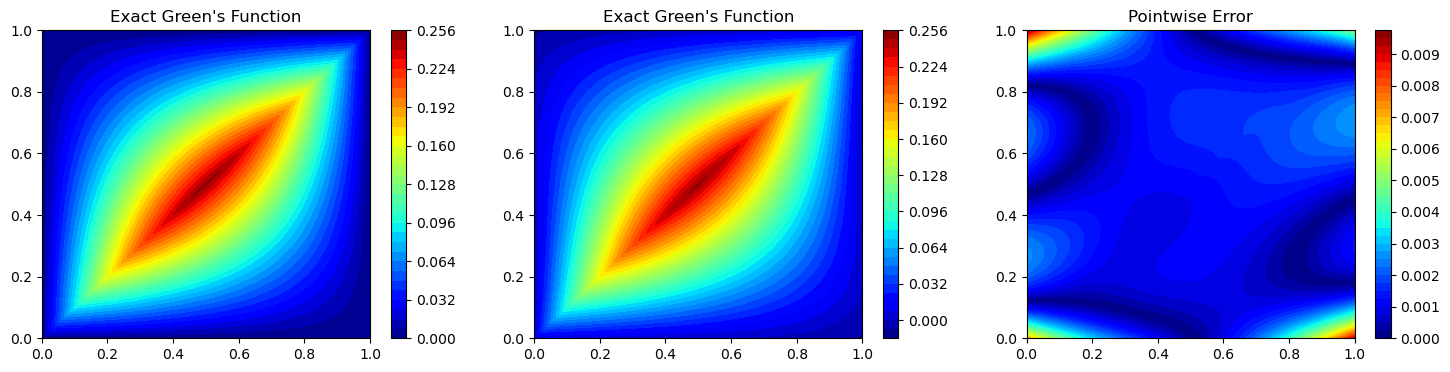

In [6]:
# report numerical approximation of the exact Green's function
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# exact Green's function
G_exact_test = Green_Exact_Line1D(X, Y)
contour1 = ax1.contourf(X, Y, G_exact_test, 40, cmap='jet')
ax1.set_title("Exact Green's Function")
plt.colorbar(contour1, ax=ax1)

# approximate Green's function
contour2 = ax2.contourf(X, Y, G_NN_test, 40, cmap='jet')
ax2.set_title("Exact Green's Function")
plt.colorbar(contour2, ax=ax2)

# pointwise error
contour3 = ax3.contourf(X, Y, np.abs(G_exact_test - G_NN_test), 40, cmap='jet')
ax3.set_title("Pointwise Error")
plt.colorbar(contour3, ax=ax3)

# Show plot
plt.show()

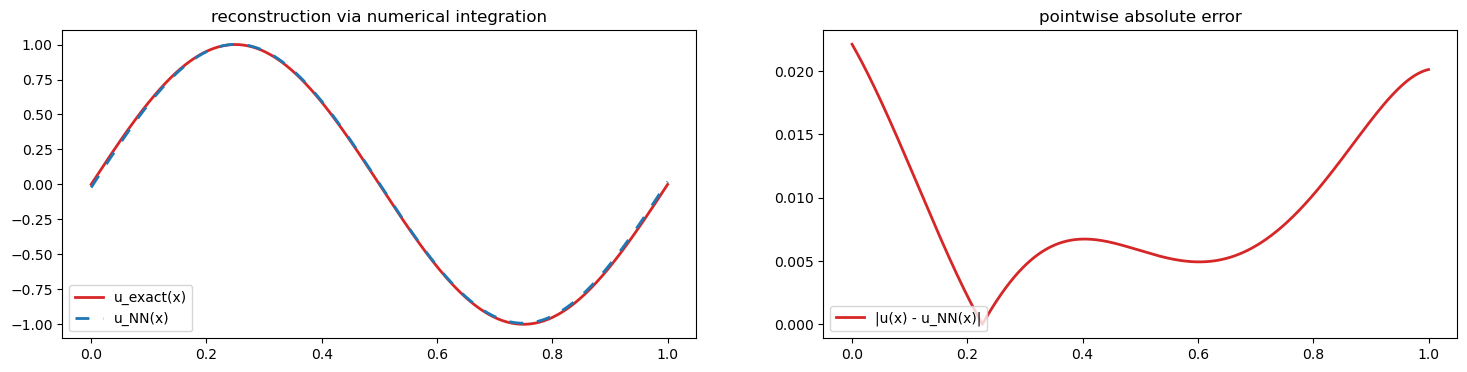

In [7]:
# test example for application as a fast solver
def u_Exact_Fast_Solver(x):
    return np.sin( 2 * np.pi * x )

def f_Exact_Fast_Solver(x):
    return  4 * np.pi**2 * np.sin( 2 * np.pi * x )

u_NN = torch.matmul(G_NN_test, f_Exact_Fast_Solver(x))/1000

fig = plt.figure(figsize=(18, 4), dpi= 100)

plt.subplot(1, 2, 1)
plt.plot(x, u_Exact_Fast_Solver(x), linewidth=2.0, label="u_exact(x)", color="tab:red")
plt.plot(x, u_NN, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_NN(x)", color="tab:blue")
plt.title('reconstruction via numerical integration')
plt.legend(loc = 'lower left')

plt.subplot(1, 2, 2)
plt.plot(x, np.abs(u_Exact_Fast_Solver(x) - u_NN), linewidth=2.0, label="|u(x) - u_NN(x)|", color="tab:red")
plt.title('pointwise absolute error')
plt.legend(loc = 'lower left')

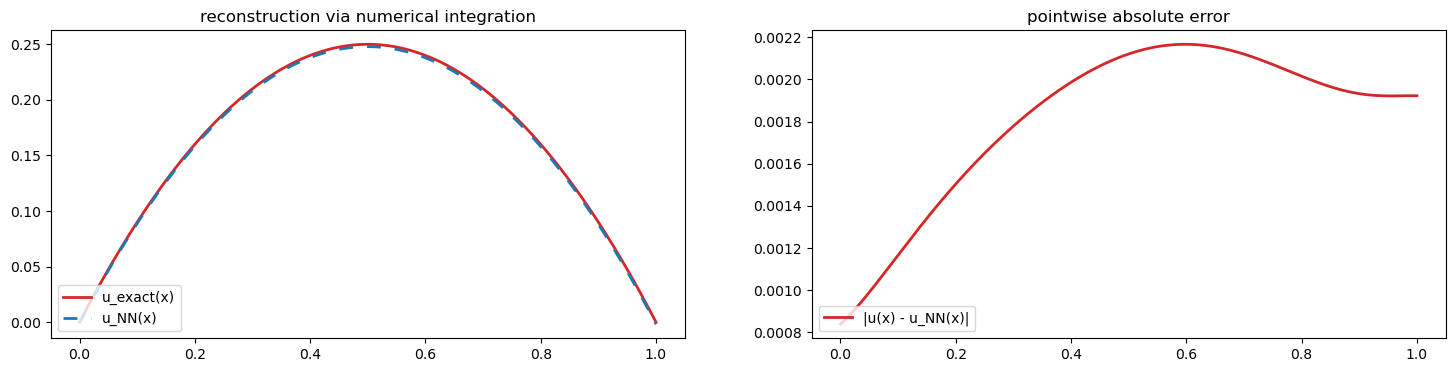

In [9]:
# test example for application as a fast solver
def u_Exact_Fast_Solver(x):
    return x * (1-x)

def f_Exact_Fast_Solver(x):
    return  2 + 0*x

u_NN = torch.matmul(G_NN_test, f_Exact_Fast_Solver(x))/1000

fig = plt.figure(figsize=(18, 4), dpi= 100)

plt.subplot(1, 2, 1)
plt.plot(x, u_Exact_Fast_Solver(x), linewidth=2.0, label="u_exact(x)", color="tab:red")
plt.plot(x, u_NN, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_NN(x)", color="tab:blue")
plt.title('reconstruction via numerical integration')
plt.legend(loc = 'lower left')

plt.subplot(1, 2, 2)
plt.plot(x, np.abs(u_Exact_Fast_Solver(x) - u_NN), linewidth=2.0, label="|u(x) - u_NN(x)|", color="tab:red")
plt.title('pointwise absolute error')
plt.legend(loc = 'lower left')

## 4. 课后练习（Talk is cheap. Show me the code.）

考虑均匀梁在载荷 $f(x)$ 作用下的微小挠度 $u(x)$ 时，通过欧拉-伯努利理论可知梁的平衡状态满足四阶椭圆方程，即
$$
\begin{array}{cl}
    - u''''(x) = f(x), \ \ \ & \ \textnormal{for}\ x\in\Omega = (0,1), \\
    u(x) = u''(x) = 0, \ \ \ & \ \textnormal{for}\ x\in \partial\Omega = \{0,1\}
\end{array}
$$
其中位移和弯矩为零，相应的格林函数 $G(x,y)$ 满足：对任一固定 $y\in\Omega = (0,1)$，
$$
\begin{array}{cl}
	- \partial_{xxxx} G(x,y) = \delta(x-y), \ \ \ & \ \textnormal{for}\ x\in\Omega = (0,1), \\
	G(x,y) = \partial_{xx}G(x,y) = 0, \ \ \ & \ \textnormal{for}\ x\in \partial\Omega = \{0,1\},
\end{array}
$$
特别的，通过对 $\delta(\cdot)$ 函数进行积分，格林函数所满足的方程也可等价写为：对任一固定 $y\in\Omega$， 
$$
\begin{array}{cl}
    -\partial_{xxxx} G(x,y) = 0, \ \ \ & \ \textnormal{for}\ x\in(0,y)\cup(y,1), \\
    【G(x,y)】=【\partial_{x}G(x,y)】=【\partial_{xx}G(x,y)】= 0,\ 【\partial_{xxx} G(x,y) 】 = -1, \ \ \ &\ \textnormal{for}\ x\in\Gamma = \{ x \,|\, x=y\},\\
	G(x,y) = \partial_{xx}G(x,y) = 0. \ \ \ &\ \textnormal{for}\ x\in\partial\Omega = \{0,1\}.
\end{array}
$$

请运用机器学习方法求解该问题，将结果与真实解进行比较，并将其应用于四阶椭圆方程的快速求解。
$$
G(x,y) = \left\{
\begin{array}{cl}
	\frac{1}{6}x(y-1) ( 2y - y^2 - x^2), \ \ \ & \ \textnormal{for}\ x < y, \\
	\frac{1}{6}y(x-1) ( 2x - x^2 - y^2), \ \ \ & \ \textnormal{for}\ x>y.
\end{array}\right.
$$